In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import os 
import sys 

current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    
from pipeline.plotting.TS_analysis import plot_TS
from jupyter_ipynb.NetMob_training_analysis.plotting import plot_boxplot_on_metric
from experiences.convert_df_to_latex import dataframe_to_latex,parse_index_exp1_2,parse_index_exp4
from experiences.contextual_data_integration.B_data_quantity.exp5_results import results


folder_path = 'save/K_fold_validation/training_wo_HP_tuning'

In [50]:


def results_to_dataframe(results):
    """
    Cette fonction transforme les résultats bruts en un DataFrame pandas.
    """
    data = []
    for line in results.strip().split('\n'):
        if not line.strip():
            continue
        
        parts = line.split(':')
        name = parts[0].strip()
        metrics = parts[1].strip()
        
        target_match = re.search(r'(bike_out|subway_out)', name)
        target = target_match.group(1) if target_match else 'unknown'
        
        contextual_data = target
        if 'weather' in name and 'subway_in' in name:
            contextual_data = f"{target} + subway-in + weather"
        elif 'weather' in name:
            contextual_data = f"{target}_weather"
        elif 'subway_in' in name:
            contextual_data = f"{target} + subway in"
        
        percentage_match = re.search(r'(\d+)p', name) 
        percentage = int(percentage_match.group(1)) if percentage_match else -1
        
        horizon_match = re.search(r'_h(\d+)_', name)
        horizon = int(horizon_match.group(1)) if horizon_match else -1

        bis_match = re.search(r'bis(\d)', name)
        bis = int(bis_match.group(1)) if bis_match else -1
        
        rmse_match = re.search(r'RMSE = ([\d.]+)', metrics)
        rmse = float(rmse_match.group(1)) if rmse_match else -1.0
        
        mae_match = re.search(r'MAE = ([\d.]+)', metrics)
        mae = float(mae_match.group(1)) if mae_match else -1.0
        
        mase_match = re.search(r'MASE = ([\d.]+)', metrics)
        mase = float(mase_match.group(1)) if mase_match else -1.0
        
        data.append([target, contextual_data, percentage, horizon, bis, rmse, mae, mase])
        
    df = pd.DataFrame(data, columns=['target', 'contextual_data', 'percentage','horizon', 'bis', 'RMSE', 'MAE', 'MASE'])
    return df

def plot_metrics(df, target_name, configurations,folder_path):
    """
    This function plots RMSE, MAE, and MASE metrics for different configurations and training data percentages.
    """
    metrics = ['RMSE', 'MAE', 'MASE']

    for horizon in sorted(df['horizon'].unique()):
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
        fig.suptitle(f'Prediction of {target_name.replace("_", " ")} at horizon {horizon} according to training data quantity', fontsize=16)

        colors = plt.cm.viridis(np.linspace(0, 1, len(configurations)))
        colors = plt.cm.get_cmap('Dark2', len(configurations)).colors

        for i, metric in enumerate(metrics):
            ax = axes[i]

            for color, config in zip(colors, configurations):

                subset = df[(df['contextual_data'] == config) & (df['horizon'] == horizon)]
                
                if subset.empty:
                    continue


                grouped = subset.groupby(['horizon','percentage'])[metric]


                
                mean_metric = grouped.mean()
                min_metric = grouped.min()
                max_metric = grouped.max()

                percentages = sorted(subset['percentage'].unique())
                
                label = config.replace(f"{target_name}", "").replace("_", " ").strip()
                if not label:
                    label = target_name.replace("_", " ")

                ax.plot(percentages, mean_metric, marker='o', linestyle='-', label=label, color=color)
                ax.fill_between(percentages, min_metric, max_metric, alpha=0.2, color=color)

            ax.set_title(metric)
            ax.set_xlabel('Pourcentage of training data used (%)')
            ax.set_ylabel(metric)
            ax.grid(True)
            ax.legend()
            
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        if folder_path is not None: 
            plt.savefig(f"{folder_path}/{target_name}_h{horizon}_metrics_comparison.png")
        plt.show()


df = results_to_dataframe(results)


display(df)

,target,contextual_data,percentage,horizon,bis,RMSE,MAE,MASE
0,bike_out,bike_out,5,1,1,4.801,3.081,0.800
1,bike_out,bike_out,5,1,2,4.765,3.034,0.788
2,bike_out,bike_out,5,1,3,4.725,3.015,0.783
3,bike_out,bike_out,5,1,4,4.720,3.042,0.790
4,bike_out,bike_out,5,1,5,4.816,3.077,0.799
...,...,...,...,...,...,...,...,...
345,subway_out,subway_out + subway-in + weather,100,4,1,40.983,22.599,0.704
346,subway_out,subway_out + subway-in + weather,100,4,2,40.494,22.291,0.694
347,subway_out,subway_out + subway-in + weather,100,4,3,40.683,22.715,0.707
348,subway_out,subway_out + subway-in + weather,100,4,4,40.690,22.480,0.700


/tmp/ipykernel_123862/1744896935.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Dark2', len(configurations)).colors


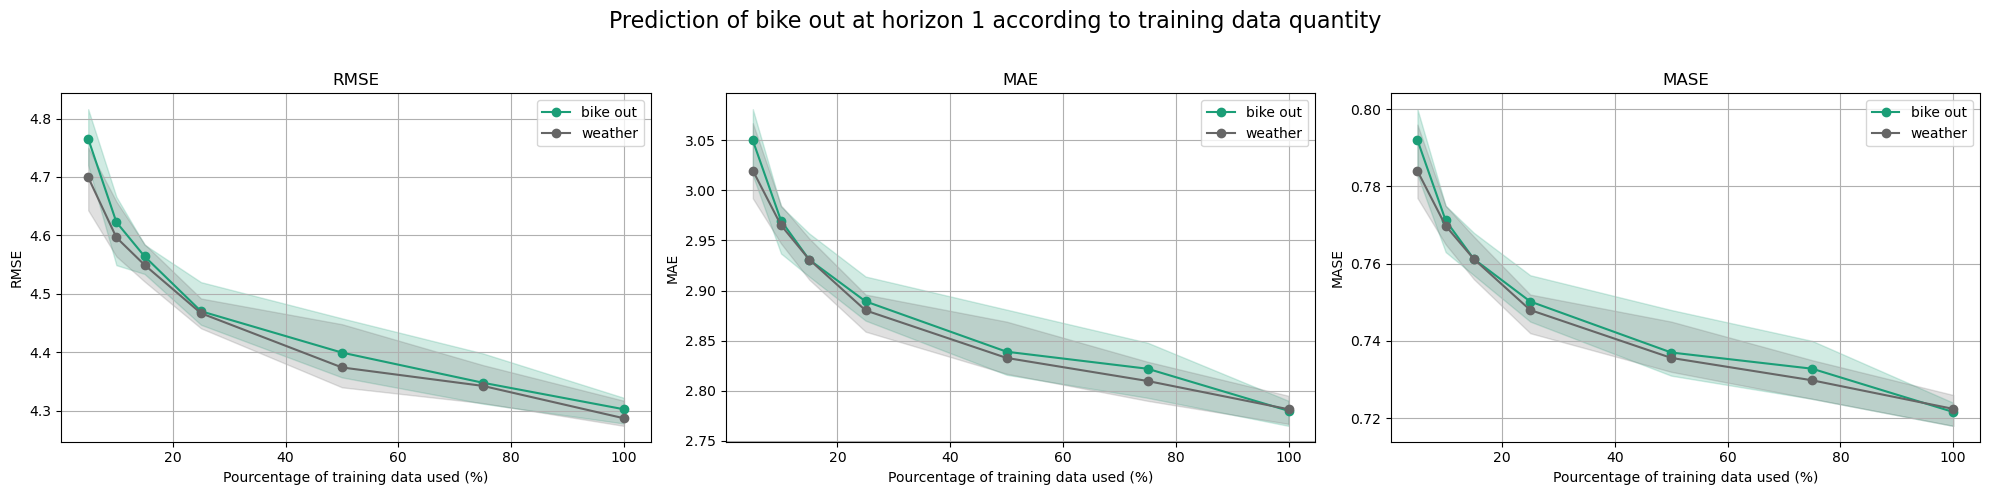

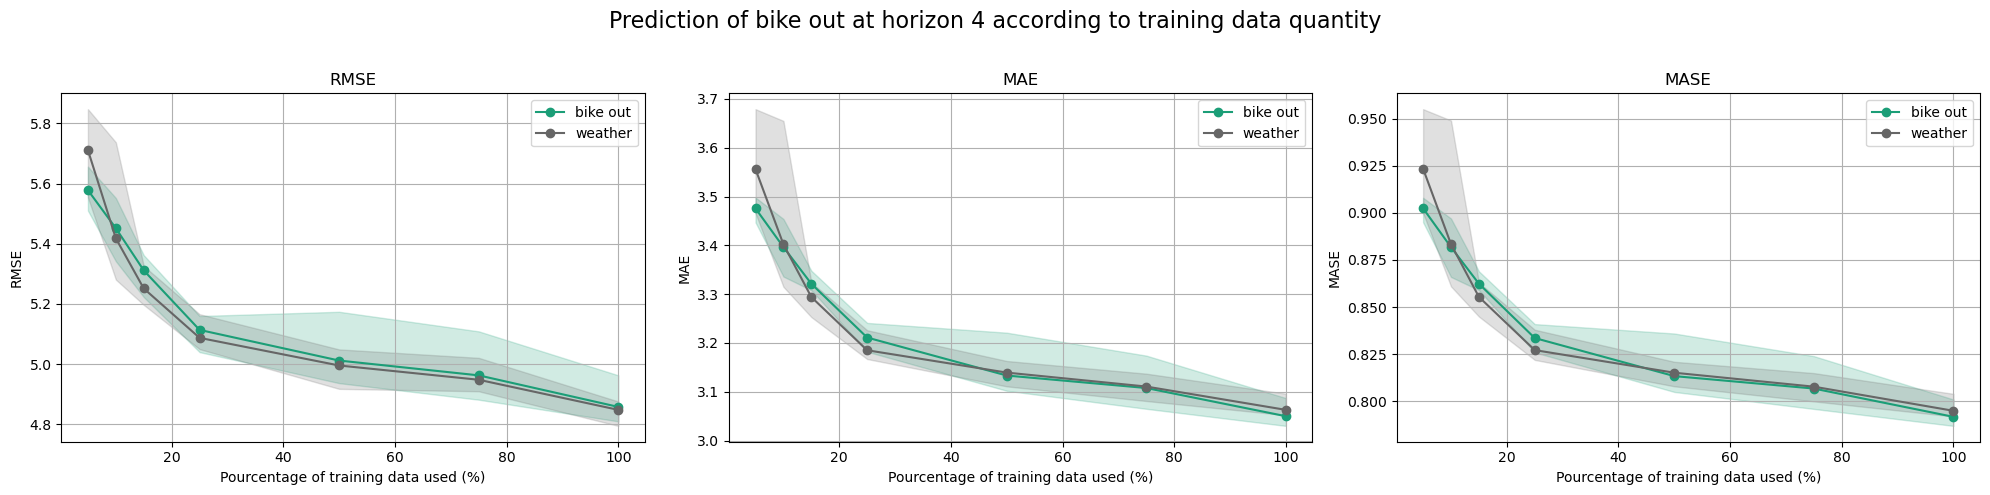

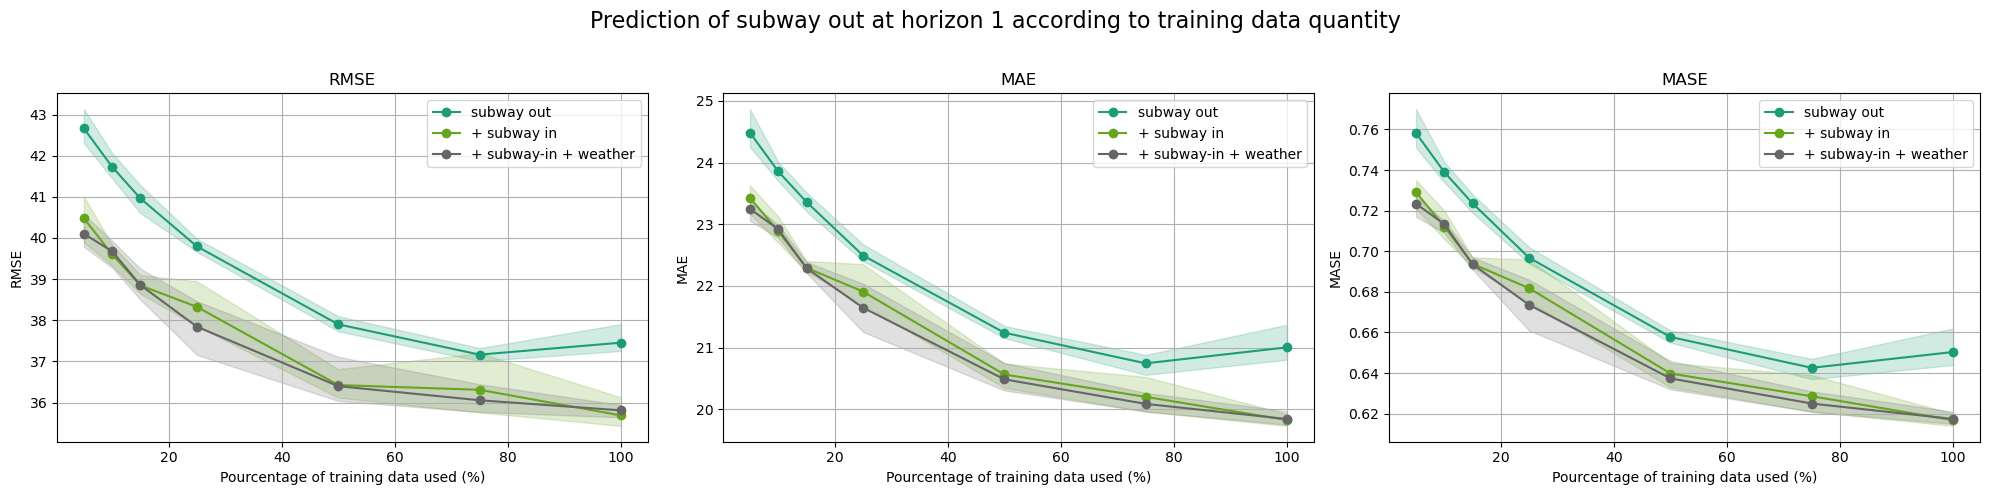

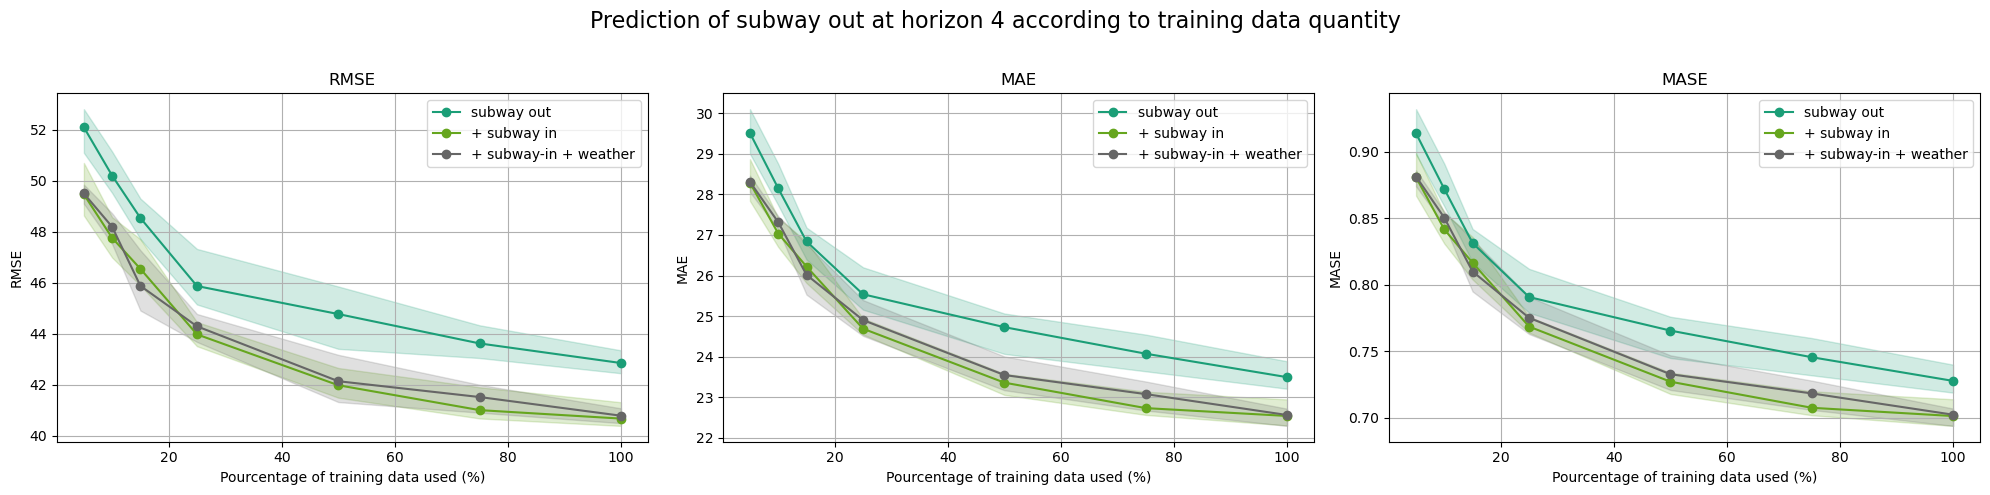

In [51]:
save_folder_path = 'experiences/contextual_data_integration/B_data_quantity/plots'

bike_out_configs = ['bike_out', 'bike_out_weather']
plot_metrics(df[df['target'] == 'bike_out'], 'bike_out', bike_out_configs,save_folder_path)

subway_out_configs = ['subway_out', 'subway_out + subway in', 'subway_out + subway-in + weather']
plot_metrics(df[df['target'] == 'subway_out'], 'subway_out', subway_out_configs,save_folder_path)

In [96]:
# Load saved results and apply it on rainy day : 
# ----------
# 1. For Each Target, for each config with, for each horizon, for each bis:
#       i. load datset, model, and trainer 
#       ii. load saved model weights 
# 2. Forward prediction, get desagregated metrics 

# 3. Get RMSE, MAE, MASE, MAPE on rainy day with the format:
#   f"{model_name}_{target_name}_{contextual_data}_{fusion_strategie}_{feature_extractor}_p{percentage}__e{epochs}h{horizon}_bis{bis}:   All Steps RMSE = {RMSE:.3f}, MAE = {MAE:.3f}, MASE = {MASE:.3f}, MAPE = {MAPE:.3f}"

 
# -- Config Init 
from examples.accuracy_comparison import load_trainer_ds_from_2_trials,get_predict_real_and_inputs,get_model_args
from examples.accuracy_comparison import get_rainy_indices,plot_analysis_comparison_2_config,print_global_info,get_previous_and_prediction,get_gain_from_mod1
import torch 
from pipeline.utils.metrics import evaluate_metrics

def get_dict_metrics_on_rainy_events(full_predict1,full_predict2,Y_true,X,args_init1,args_init2,ds2):
    h_idx = 1
    metric_list = ['rmse','mse','mae','mase','mape']
    previous,_,_,_ = get_previous_and_prediction(full_predict1,full_predict2,Y_true,X,h_idx)
    assert args_init1.horizon_step == args_init1.step_ahead, "Horizon step must be equal to step_ahead here"

    print("\nComparison on between models across all time-slots followed by comparison on Rainy Events Only")
    _,train_rainy_indices,_ = get_rainy_indices(args = args_init2,ds = ds2,training_mode = 'train')
    print(f"Number of rainy time-slots in the train set: {len(train_rainy_indices)}, i.e {len(train_rainy_indices)/len(ds2.tensor_limits_keeper.df_verif_train)*100:.2f} % of the train set")
    # ---- Plot Accuracy comparison on rainy moments only ----
    mask,rainy_indices,df_weather = get_rainy_indices(args = args_init2,ds = ds2,training_mode = 'test')
    print(f"Number of rainy time-slots in the test set: {len(rainy_indices)}, i.e {len(rainy_indices)/len(ds2.tensor_limits_keeper.df_verif_test)*100:.2f} % of the test set\n")

    dates = mask[mask].index
    masked_index = mask.reset_index(drop=True)
    masked_index = masked_index[masked_index].index


    # --- Get Prediction on rainy time-slots:
    rainy_predict1 = torch.index_select(full_predict1,0,torch.tensor(masked_index).long())
    rainy_predict2 = torch.index_select(full_predict2,0,torch.tensor(masked_index).long())
    rainy_Y_true = torch.index_select(Y_true,0,torch.tensor(masked_index).long())
    rainy_previous = torch.index_select(previous,0,torch.tensor(masked_index).long())

    dic_metric1 = evaluate_metrics(rainy_predict1,rainy_Y_true,metrics = metric_list, previous = rainy_previous,horizon_step = h_idx)
    dic_metric1 = dict(dic_metric1.copy())
    dic_metric2 = evaluate_metrics(rainy_predict2,rainy_Y_true,metrics = metric_list, previous = rainy_previous,horizon_step = h_idx)
    dic_metric2 = dict(dic_metric2.copy())
    return dic_metric1,dic_metric2



dic_contextual_data = {'bike_out': [[],['weather','calendar']],
                    'subway_out': [[],['subway_in','calendar'],['subway_in','weather','calendar']]
                    }

dic_fusion_strategie = {('bike_out',()): '',
                        ('bike_out',('weather','calendar')):'early_fusion',
                        ('subway_out',()):'',
                        ('subway_out',('subway_in','calendar')):'early_fusion',
                        ('subway_out',('subway_in','weather','calendar')):'early_fusion'
                        }
             
dic_feature_extractor = {('bike_out',()): '',
                        ('bike_out',('weather','calendar')):'repeat_t_proj',
                        ('subway_out',()):'',
                        ('subway_out',('subway_in','calendar')):'shared_embedding',
                        ('subway_out',('subway_in','weather','calendar')):'shared_embedding_repeat_t_proj'
                        }


model_name = 'STAEformer'
epochs = 50
range_k = range(1,6)
training_mode = 'test'
modification = {'shuffle':False,
                'data_augmentation':False,
                'torch_compile': False,
                }
log = ''
for percentage in [5, 10, 15, 25, 50, 75, 100]:
    for horizon in [1,4]:
        for target in ['bike_out','subway_out']:
            for contextual_data in dic_contextual_data[target]:
                reversed_metric = False
                fusion_strategie = dic_fusion_strategie[(target,tuple(contextual_data))]
                feature_extractor = dic_feature_extractor[(target,tuple(contextual_data))]
                    
                
                if not('weather' in contextual_data):
                    contextual_data1 = ['weather','calendar'] if target == 'bike_out' else ['subway_in','weather','calendar']
                    fusion_strategie1 = dic_fusion_strategie[(target,tuple(contextual_data1))]
                    feature_extractor1 = dic_feature_extractor[(target,tuple(contextual_data1))]

                    if contextual_data == []:
                        trial_id1 = f"{model_name}_{target}_{percentage}p__e{epochs}_h{horizon}_bis"
                    else:
                        trial_id1 = f"{model_name}_{target}_{'_'.join(contextual_data)}_{fusion_strategie}_{feature_extractor}_{percentage}p__e{epochs}_h{horizon}_bis"

                    trial_id2 = f"{model_name}_{target}_{'_'.join(contextual_data1)}_{fusion_strategie1}_{feature_extractor1}_{percentage}p__e{epochs}_h{horizon}_bis"
                    reversed_metric = True 
                else:
                    trial_id1 = f"{model_name}_{target}_{percentage}p__e{epochs}_h{horizon}_bis"
                    trial_id2 = f"{model_name}_{target}_{'_'.join(contextual_data)}_{fusion_strategie}_{feature_extractor}_{percentage}p__e{epochs}_h{horizon}_bis"

                model_args,_,path_model_args,_ = get_model_args(target,model_name,save_folder_name = f'Exp5/{target}_{model_name}')
                ds1,ds2,args_init1,args_init2 = None, None, None, None

                for k in range_k:
                    trial_id1_updated = f"{trial_id1}{k}_f5"
                    trial_id2_updated = f"{trial_id2}{k}_f5"

                    trainer1,trainer2,ds1,ds2,args_init1,args_init2 = load_trainer_ds_from_2_trials(trial_id1_updated,trial_id2_updated,modification = modification,
                                                                                                    model_args=model_args,
                                                                                                    path_model_args=path_model_args,
                                                                                                    ds1_init=ds1,ds2_init=ds2,
                                                                                                    args_init1=args_init1,args_init2=args_init2,
                                                                                                    )
                                                                                                    

                    full_predict1,full_predict2,Y_true,X = get_predict_real_and_inputs(trainer1,trainer2,ds1,ds2,training_mode=training_mode)

                    globals()[f"trainer1_bis{k}"] = trainer1
                    globals()[f"trainer2_bis{k}"] = trainer2
                    globals()[f"ds1_bis{k}"] = ds1
                    globals()[f"ds2_bis{k}"] = ds2
                    globals()[f"full_predict1_bis{k}"] = full_predict1
                    globals()[f"full_predict2_bis{k}"] = full_predict2

                    dic_metric1,dic_metric2 = get_dict_metrics_on_rainy_events(globals()[f"full_predict1_bis{k}"],globals()[f"full_predict2_bis{k}"],Y_true,X,args_init1,args_init2,ds2)

                    # Keep track on metric from model 1
                    if reversed_metric:
                        dic_metric2 = dict(dic_metric1.copy())
                    RMSE = dic_metric2['rmse_all']
                    MAE = dic_metric2['mae_all']
                    MASE = dic_metric2['mase_all']
                    MAPE = dic_metric2['mape_all']
                    if feature_extractor == '':
                        log += f"{model_name}_{target}_p{percentage}__e{epochs}h{horizon}_bis{k}:   All Steps RMSE = {RMSE:.3f}, MAE = {MAE:.3f}, MASE = {MASE:.3f}, MAPE = {MAPE:.3f}\n"
                    else:
                        log += f"{model_name}_{target}_{'_'.join(contextual_data)}_{fusion_strategie}_{feature_extractor}_p{percentage}__e{epochs}h{horizon}_bis{k}:   All Steps RMSE = {RMSE:.3f}, MAE = {MAE:.3f}, MASE = {MASE:.3f}, MAPE = {MAPE:.3f}\n"
                print(log)

Trial ID 1:  STAEformer_bike_out_5p__e50_h1_bis1_f5
Trial ID 2:  STAEformer_bike_out_weather_calendar_early_fusion_repeat_t_proj_5p__e50_h1_bis1_f5
model_save_path for trial id1:  /home/rrochas/prediction-validation/save/K_fold_validation/training_wo_HP_tuning/Exp5/bike_out_STAEformer/best_models/STAEformer_bike_out_5p__e50_h1_bis1_f5.pkl
----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 35040 elts between 2019-01-01 00:00:00 and 2019-12-31 23:45:00
Invalid dates within this fold: 0

>>>Tackle Target dataset: bike_out
Loading from /home/rrochas/../../data/rrochas/prediction_validation/agg_data/velov/velov_emitted_by_station15min.csv...
df pivoted:  (70049, 434)
df reindexed :  (35040, 434)
Len coverage period:  35040
df filtered:  (35040, 434)
   Loaded data: (35040, 434)
   Dimension after spatial agg: (35040, 26)
   Init Dataset: 'torch.Size([35040, 26]). 0 Nan values
   TRAIN contextual_ds: torch.Size([15724, 26, 7])
   VALID

KeyboardInterrupt: 